In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

import fantasy_agn.models as FantasyModels
from fantasy_agn.tools import make_spec

import agnfitlab.models as AGNFitLabModels
import agnfitlab.instrument as inst

In [2]:
wmin = 5000
wmax = 6000

In [3]:
path_to_folder='testfit/'
FantasyModels.create_input_folder(xmin=wmin, xmax=wmax, path_to_folder=path_to_folder)
AGNFitLabModels.set_path(path_to_folder)

# Create a fake spectrum starting from a very narrow model
narrow_m = AGNFitLabModels.create_fixed_model(['narrow_plus.csv'], name='Test',
                                         fwhm=10, min_fwhm=1e-5, max_fwhm=1000,
                                         offset=0., min_offset=-500, max_offset=500,
                                         amplitude=10, min_amplitude=0, max_amplitude=1000,
                                         profile='lorentz')

Directory  testfit/  Created 


In [4]:
narrow_m

<Fixed_Lines model instance 'Test'>

In [5]:
# Load the response matrix
rsploader = inst.InstRspLoader(inst='MUSE')

In [6]:
# Create the wavelength array for the fake spectrum cropping the rsploader.wave array to the wmin and wmax
wave = rsploader.wave[(rsploader.wave >= wmin) & (rsploader.wave <= wmax)]

# Create the narrow fake spectrum
source_spectrum = narrow_m(wave)

In [7]:
# Crop the response matrix to the same wavelength range
rsp_matrix = rsploader.crop_matrix(wave=wave)

# Instantiate the response matrix model
rsp = inst.SpectralRsp(rsp_matrix)
rspmod = rsp(narrow_m)

In [8]:
# Simulate the spectrum adding noise to the 
observed_spectrum = rspmod(wave)

err_mag = 0.2
err = np.zeros_like(observed_spectrum) + err_mag
observed_spectrum += np.random.normal(0, err_mag, len(observed_spectrum))

In [9]:
# Fit the spectrum with the narrow model and with the repsonse model
fspec = make_spec(wav=wave, fl=observed_spectrum, er=err)

fspec.fit(narrow_m, ntrial=10)
narrow_mod_arr = fspec.model(wave)

iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10


In [10]:
fspec.model

<Fixed_Lines model instance 'Test'>

In [11]:
fspec.fit(rspmod, ntrial=10)
rsp_mod_arr = fspec.model(wave)

iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10


In [12]:
fspec.model

<ConvolvedModel model instance 'instrsp(Test)'>

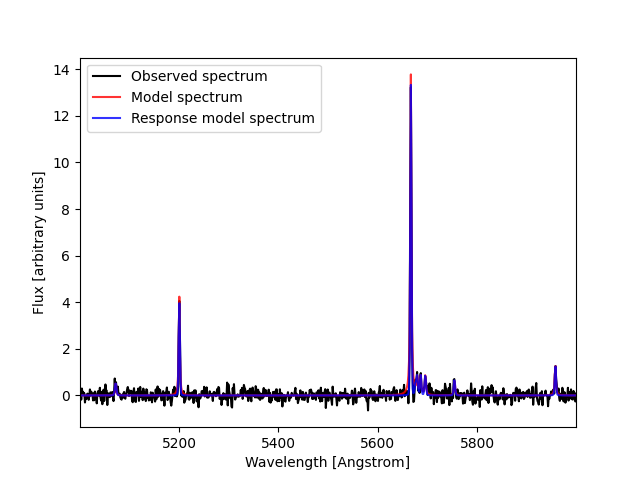

In [13]:
plt.figure()
plt.plot(wave, observed_spectrum, 'k-', label='Observed spectrum')
plt.plot(wave, narrow_mod_arr, 'r-', label='Model spectrum', alpha=0.8)
plt.plot(wave, rsp_mod_arr, 'b-', label='Response model spectrum', alpha=0.8)
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Flux [arbitrary units]')
plt.legend()
plt.margins(x=0)
plt.show()

In [14]:
import shutil
shutil.rmtree(path_to_folder)